# Formular la pregunta

### "Cuál es la probabilidad que un tweet que origina dentro de los coordinados geográficos (-78.31, 0.44, -70.71, 11.39) contiene al menos una ocurrencia de la palabra 'yo' con cualquier composición de acentos y letras minúsculas y mayúsculas."

![](http://mediossociales.es/wp-content/uploads/2012/01/twitter_futbol12.jpg)

# Recopilar datos

In [1]:
import os

import tweepy
from tweepy import Stream

from stream_listener import FiniteStreamListener

### Cargar credenciales

In [2]:
CONSUMER_KEY = os.getenv('DS_TWITTER_CONSUMER_KEY')
CONSUMER_SECRET = os.getenv('DS_TWITTER_CONSUMER_SECRET')
ACCESS_TOKEN = os.getenv('DS_TWITTER_ACCESS_TOKEN')
ACCESS_TOKEN_SECRET = os.getenv('DS_TWITTER_ACCESS_TOKEN_SECRET')

In [3]:
SPAIN_GEO_LOCATION_BOUNDING_BOX = [-18.16, 27.64, 4.33, 43.79]
NUMBER_OF_TWEETS = 100

In [4]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

### Establecer una conexión al API de Twitter

In [5]:
finite_stream_listener = FiniteStreamListener(number_of_tweets=NUMBER_OF_TWEETS)
streaming_api = Stream(auth=auth, listener=finite_stream_listener)

### Sorber del firehouse

In [6]:
streaming_api.filter(locations=SPAIN_GEO_LOCATION_BOUNDING_BOX)

# Limpiar datos

In [7]:
from unidecode import unidecode

### Definir funciones de limpieza

In [8]:
def make_lowercase(tweet):
    return tweet.lower()

def remove_diacritics(tweet):
    return unidecode(tweet)

def remove_non_alpha_characters(tweet):
    return ''.join(character for character in tweet if character.isalpha() or character== " ")

### Aplicar las funciones

In [20]:
cleaned_tweets = list(finite_stream_listener.tweets)

for cleaning_function in [make_lowercase, remove_diacritics, remove_non_alpha_characters]:
    cleaned_tweets = [cleaning_function(tweet) for tweet in cleaned_tweets]

# Dormir con tus datos

In [21]:
from pprint import pprint
import pandas as pd

In [22]:
KEYWORD = "yo"

### Primeros 10 tweets

In [23]:
pprint(cleaned_tweets[:10])

['que mania y facilidad tiene la gente pa tocarme los huevos eh',
 'adoro a minha arvore de natal ',
 'mariiasafi vamonos de la vida  httpstcoiahgvrcgf',
 'dillyas faz o que eu digo nao facas o que eu faco',
 'snookerpunter nice mate good luck',
 'danipacheco albertogarcia ayer nos hicisteis disfrutar mucho a la aficion gracias',
 'canaltcm habra que grabarla ',
 'noticia del anos ue suspendera la relacion politica con austria si la ultraderecha entra en el gobiernoy en el stopfascismo',
 'como se llamaba esta serie por dios necesito verla de nuevo httpstcoayzwhvnty',
 'en nada estare con mis babes']


### ¿Cuantas veces aparece la palabra clave?

In [24]:
number_of_occurences = sum(KEYWORD in tweet for tweet in cleaned_tweets)
print('Nuestra palabra clave aparece {} veces.').format(number_of_occurences)

Nuestra palabra clave aparece 1 veces.


### ¿Con cual frecuencia apareció?

In [25]:
print('Nuestra pañabra clave apareció en el {}% de los tweets.').format(100 * number_of_occurences/NUMBER_OF_TWEETS)

Nuestra pañabra clave apareció en el 1% de los tweets.


### ¿Cómo son los tweets que la contienen?

In [26]:
pprint([tweet for tweet in cleaned_tweets if KEYWORD in tweet])

['happy birthday belvsss hope you had an amazing one miss ya fil classmate ']


### ¿Cuál es la distancia promedia entre ocurrencias consecutivas?

In [27]:
index_of_tweets_containing_keyword = [index for index, tweet in enumerate(cleaned_tweets) if KEYWORD in tweet]

In [28]:
index_of_tweets_containing_keyword

[11]

In [29]:
distances_between_index_of_tweets_containig_keyword = [
    second_index - first_index for first_index, second_index in \
        zip(index_of_tweets_containing_keyword[:-1], index_of_tweets_containing_keyword[1:])
]

In [30]:
pd.Series(distances_between_index_of_tweets_containig_keyword).hist()

# Construir un modelo

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta as beta_distribution

### Definir los parámetros de un Beta Distribution

In [34]:
alpha = 1 + number_of_occurences
beta = 1 + (NUMBER_OF_TWEETS -  number_of_occurences)

x_values = np.linspace(0, 1, 1002)[1:-1]
pdf_y_values = beta_distribution(alpha, beta).pdf(x_values)
cdf_y_values = np.cumsum(pdf_y_values) / np.sum(pdf_y_values)

### Visualizar

![](http://i.imgur.com/mj059cS.png)

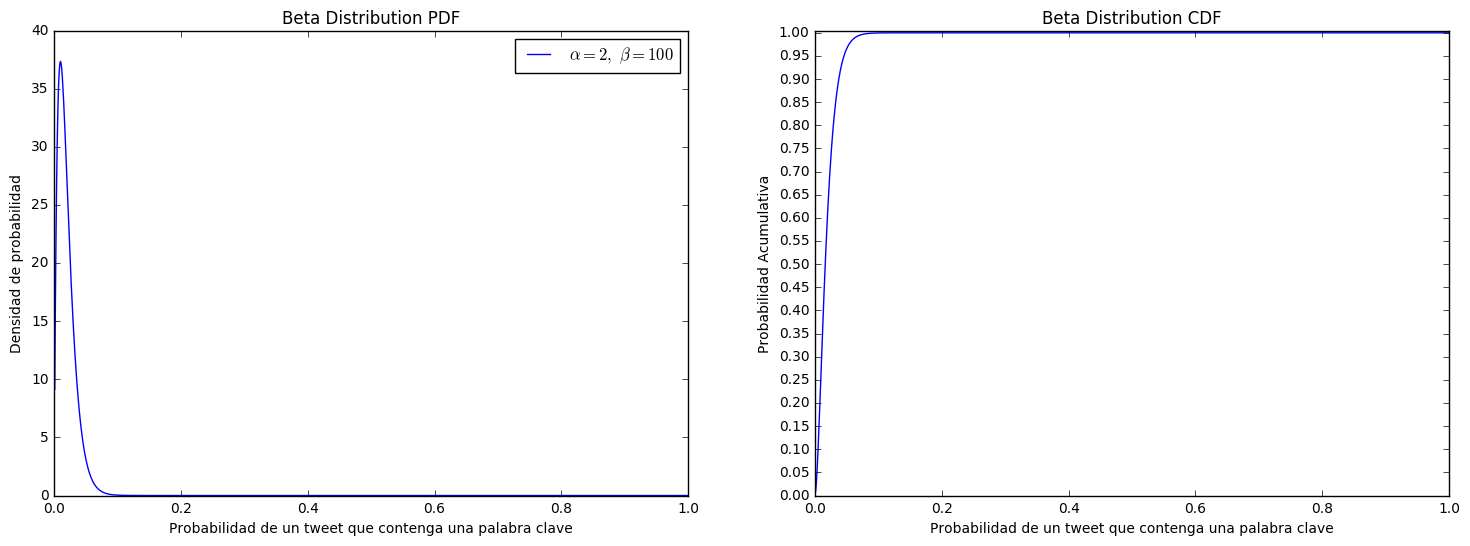

In [37]:
plt.figure(figsize=(18,6))

#PDF
plt.subplot(121)
plt.plot(x_values, pdf_y_values, label=(r'$\alpha=%.lf,\ \beta=%.lf$' % (alpha, beta)))

plt.xlim(0, 1)
plt.xlabel('Probabilidad de un tweet que contenga una palabra clave')
plt.ylabel('Densidad de probabilidad')
plt.title('Beta Distribution PDF')
plt.legend(loc=1)


#CDF
plt.subplot(122)
plt.plot(x_values, cdf_y_values)

plt.xlim(0, 1)
plt.ylim(0, 1.005)
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel('Probabilidad de un tweet que contenga una palabra clave')
plt.ylabel('Probabilidad Acumulativa')
plt.title('Beta Distribution CDF')

plt.show()

# Comunicar resultados

### Con 90% de certeza, digamos que la verdadera probabilidad:

In [39]:
fifth_percentage = max(
    [x_value for x_value, y_value in zip(x_values, cdf_y_values) if y_value <= .05]
)
ninety_fifth_percentage = max(
    [x_value for x_value, y_value in zip(x_values, cdf_y_values) if y_value <= .95]
)

In [43]:
print('Con 90% de certeza podemos decir que la probabilidad se encuentra entre: {} y {}').format(round(fifth_percentage, 4), round(ninety_fifth_percentage, 4))

Con 90% de certeza podemos decir que la probabilidad se encuentra entre: 0.003 y 0.045


### La probabilidad que la verdadera probabilidad (de que un tweet contiene nuesta palabra clave) sea más grande de .1:

In [46]:
def compute_total_probability_that_probability_less_than_p(p):
    return(max(cumulative_prob for cumulative_prob, x_value in zip(cdf_y_values, x_values) if x_value < p))

In [ ]:
print('La verdadera probabilidad de que un tweet contenga la palabra clave y su probabilidad sea mayor que .1 es {}').form